# A Basic FMCW Radar Simulator <img style="float: right; width: 160px" src="../images/logo-2pi-labs.png">
--- 
<img style="float: right; height: 50px; padding-right: 15px" src="../images/cc-by-nc-sa.eu.png">

**Author**: Timo Jaeschke, 2pi-Labs GmbH \
**License**: Creative Commons [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) 

<img src="../images/sim-intro.jpg" width="100%">

This jupyter notebook gives a basic implementation of an FMCW radar simulator. It generates idealized IF-signals that you would expect from an FMCW radar system. You can use this notebook to get a better understanding of FMCW parameters and their influence on the generated signals.

To keep it simple we use the standard FMCW signal model (real part of the IF signal only):

\begin{equation}
s(t) =  A \cdot \cos \left(\dot{\omega} \tau t + \omega_{\mathrm{min}} \tau - \frac {\dot{\omega}}{2} \tau^2 - \phi_1\right)
\end{equation}

For the ease of a clean visualization the FMCW ramp deviation $\dot{\omega}$ is written as: 
\begin{equation}
\dot{\omega} = \frac{2\pi\Delta f}{T}
\end{equation}

The signal with the term $\dot{\omega} \tau t$ results in a single target environment in a IF beat frequency which is proportinal do the target distance:
\begin{equation}
f_\mathrm{ZF}=\frac{\dot{\omega}}{2\pi} \tau = \frac{\Delta f}{T} \tau = \frac{\frac{\Delta f}{T} \cdot 2 \cdot R}{c}.
\label{eq:fzf}
\end{equation}

With

|Symbol|Explanation|
|------|-----------|
|$\Delta f$|Bandwidth or "SPAN"|
|$\dot{\omega}$|Ramp deviation|
|$\tau$|Propagation delay|
|$T$|Ramp duration|
|$\omega_{\mathrm{min}}$|Minimum angular frequency|
|$R$| Target distance|
|$\phi_1$| Target reflection phase|


The implementation of the above formulas as a python function is given as presented in the following cell. We calculate the Target distance for every IF sample to allow simulation of moving targets. In addition and for a more realistic look some receiver noise is added. 

### Python / Jupyter Notebook Implementation 

In [2]:
import numpy as np
from dataclasses import dataclass
import scipy.constants as const
import scipy.signal.windows as windows

## Simulation Model Definitions
# Define Radar, Target and Processing Model as a dataclass (Python >3.7)
@dataclass
class TargetModel:
    name: str                     # Name string
    distance: float               # Target distance in m 
    velocity: float               # Target velocity in m/s
    amplitude: float              # Target amplitude
    reflection_phase: float       # Target reflection phase in degree
    
@dataclass
class RadarModel:
    name: str                     # Name string
    f_start: float                # Start frequency in Hz
    f_stop: float                 # Stop frequency in Hz
    f_if: float                   # IF sampling frequency in Hz
    t_ramp: float                 # Ramp duration in s
    sigma_rxnoise: float = 0.01   # standard deviation of added receiver noise
    
    @property
    def f_span(self):
        return self.f_stop - self.f_start # Radar bandiwdth or "span"
    
    @property
    def n_points(self):
        return int(np.round(self.f_if * self.t_ramp))
    
    # Calculate IF/Beat Signal based on Radar and Taget data and Axes 
    def simulate(self, targets):
        if_signal = np.zeros(self.n_points)
        for target in targets:
            target_distance = np.ones(self.n_points) * target.distance + np.arange(0, self.n_points) * self.t_ramp / self.n_points * target.velocity
            tau = 2 * target_distance / const.c  # Tau / Target propagation delay
            
            # Calculate resulting IF signal 
            A = 2 * np.pi * self.f_span / self.t_ramp * tau * np.arange(0, self.n_points) * self.t_ramp / self.n_points
            B = 2 * np.pi * self.f_start * tau
            C = np.pi * self.f_span / self.t_ramp * tau**2                      # may be neglected for small bandwidth sensors
            D = target.reflection_phase/360*2*np.pi
            if_signal += target.amplitude * np.cos(A+B-C-D)

        if_signal += np.random.normal(0, self.sigma_rxnoise, self.n_points)     # Add receiver noise
        return if_signal

@dataclass
class DataProcessor:
    radar: RadarModel             # Radar instance
    nfft: int = 2**16             # FFT points, IF data is zeropadded to this length       
    window: str = 'hann'          # Window function

    @classmethod
    def window_list(cls):
        return [ ('None', 'boxcar'), ('Flattop', 'flattop'), ('Hamming', 'hamming'), ('Hann', 'hann'), ('Nuttall', 'nuttall'), ('Tukey', 'tukey'), 
                 ('Bartlett-Hanning', 'barthann'), ('Bartlett', 'bartlett'), ('Blackman', 'blackman'), ('Blackman-Harris', 'blackmanharris') ]

    @property
    def ft_sweep_samples(self):
        return np.arange(0, self.radar.n_points)
    
    # Fast-Time sweep time axis
    @property
    def ft_sweep_time_axis(self):
        return self.ft_sweep_samples * self.radar.t_ramp / self.radar.n_points
    
    @property
    def ft_sweep_freq_axis(self):
        return self.radar.f_start + self.ft_sweep_samples * self.radar.f_span / self.radar.n_points
    
    @property
    def ft_range_samples(self):
        return np.arange(0, self.nfft//2)
    
    @property
    def ft_range_freq_axis(self):
        return self.ft_range_samples * self.radar.n_points / self.radar.t_ramp / self.nfft
    
    @property
    def ft_range_time_axis(self):
        return self.ft_range_samples * self.radar.n_points / np.abs(self.radar.f_span) / self.nfft
    
    @property
    def ft_range_dist_axis(self):
        return self.ft_range_samples * self.radar.n_points / np.abs(self.radar.f_span) / 2 * const.c / self.nfft
    
    def process(self, if_signal):
        # Simple range processing with windowing
        win = windows.get_window(self.window, if_signal.shape[-1], fftbins=True)  # define "periodic" window
        window_scale_factor = self.nfft / np.sum(win)                             # Calculate window function scale factor 
        if_signal = if_signal * win * window_scale_factor                             # Apply scale factor to IF data
        if_signal_spectrum = np.fft.ifft(if_signal,self.nfft)                     # Calculate IFFT 
        return if_signal_spectrum

Now, let's create a standard radar sensor with a processing configuration and two targets and print the configuration. 

In [3]:
Targets = [ TargetModel('Target0', distance=0.5, velocity=0, amplitude=1, reflection_phase=0),    # Create a first target
            TargetModel('Target1', distance=0.55, velocity=0, amplitude=1, reflection_phase=0) ]  # Create a second target
Radar = RadarModel('Radar0', f_start=126e9, f_stop=182e9, f_if=5e6, t_ramp=1e-3)                  # Configure virtual radar
Processor = DataProcessor(Radar, nfft=2**16, window='hann')                                       # Configure processing of radar

Display the radar, processing and target configuration:

In [4]:
print(f'Radar sensor configuration:')
print(f' Name:              {Radar.name}')
print(f' Start freq.:       {Radar.f_start/1e9} GHz')
print(f' Stop freq.:        {Radar.f_stop/1e9} GHz')
print(f' Bandwidth:         {(Radar.f_stop-Radar.f_start)/1e9} GHz')
print(f' IF sampling freq.: {Radar.f_if/1e6} MHz\n')

print(f'Target configuration:')
for Target in Targets:
    print(f' {Target.name}: distance: {Target.distance}, velocity: {Target.velocity}, amplitude: {Target.amplitude}, reflection phase: {Target.reflection_phase}')

print()
print(f'Processor configuration:')
print(f' Nfft:              {Processor.nfft}')
print(f' Window:            {Processor.window}')


Radar sensor configuration:
 Name:              Radar0
 Start freq.:       126.0 GHz
 Stop freq.:        182.0 GHz
 Bandwidth:         56.0 GHz
 IF sampling freq.: 5.0 MHz

Target configuration:
 Target0: distance: 0.5, velocity: 0, amplitude: 1, reflection phase: 0
 Target1: distance: 0.55, velocity: 0, amplitude: 1, reflection phase: 0

Processor configuration:
 Nfft:              65536
 Window:            hann


In [5]:
# Test of Axes Generation
print ('Sweep-Axes') 
print (f'  Samples: {Processor.ft_sweep_samples}') 
print (f'  Time: {Processor.ft_sweep_time_axis}') 
print (f'  Frequency: {Processor.ft_sweep_freq_axis}')
print()
print (f'Range-Axes') 
print (f'  Samples: {Processor.ft_range_samples}') 
print (f'  Frequency: {Processor.ft_range_freq_axis}') 
print (f'  Distance: {Processor.ft_range_dist_axis}') 

Sweep-Axes
  Samples: [   0    1    2 ... 4997 4998 4999]
  Time: [0.000e+00 2.000e-07 4.000e-07 ... 9.994e-04 9.996e-04 9.998e-04]
  Frequency: [1.260000e+11 1.260112e+11 1.260224e+11 ... 1.819664e+11 1.819776e+11
 1.819888e+11]

Range-Axes
  Samples: [    0     1     2 ... 32765 32766 32767]
  Frequency: [0.00000000e+00 7.62939453e+01 1.52587891e+02 ... 2.49977112e+06
 2.49984741e+06 2.49992371e+06]
  Distance: [0.00000000e+00 2.04217405e-04 4.08434811e-04 ... 6.69118329e+00
 6.69138750e+00 6.69159172e+00]


## Running the Simulation

Now let's test the target simulator with a single target (Target[0]) and display the IF signal in Sweep-Domain (corresponds to VNA-Frequency-Domain)

interactive(children=(FloatSlider(value=0.27, description='Target0Dist', max=1.5, min=0.001, step=0.001), Floa…

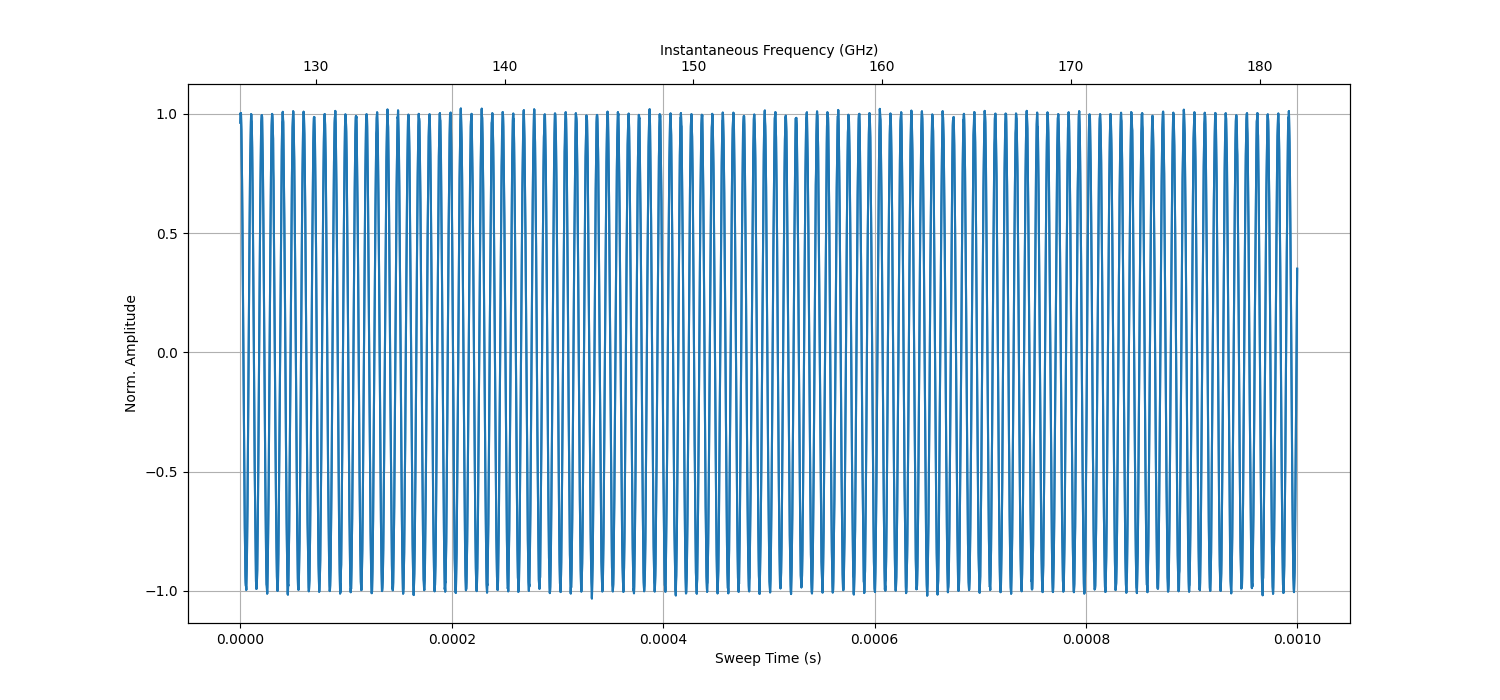

In [8]:
%matplotlib widget
import ipywidgets as interactive
import matplotlib.pyplot as plt
import numpy as np

# Create and setup plots
fig = plt.figure(figsize=(15,7))
ax_if_signal = fig.add_subplot(111)
ax_if_signal.set_xlabel('Sweep Time (s)') 
ax_if_signal.set_ylabel('Norm. Amplitude')
ax_if_signal.grid()
ax_if_signal_top = ax_if_signal.twiny()
ax_if_signal_top.set_xlabel('Instantaneous Frequency (GHz)')

@interactive.interact(Target0Dist=(0.001, 1.5, 0.001), Target0Ampl=(0.001, 1, 0.01))
def update(Target0Dist = Targets[0].distance,Target0Ampl = Targets[0].amplitude):
    # Update values
    Targets[0].distance = Target0Dist;
    Targets[0].amplitude = Target0Ampl;
    
    # Run simulation
    if_signal = Radar.simulate([Targets[0]])

    # Clear plots and re-plot
    ax_if_signal.lines.clear()
    ax_if_signal_top.lines.clear()
    
    ax_if_signal.plot(Processor.ft_sweep_time_axis, if_signal, color='C0')
    ax_if_signal_top.plot(Processor.ft_sweep_freq_axis/1e9, if_signal, color='C0')

Now let's have a closer look on how the corresponding range profile looks like in the Range-Domain (corresponds to VNA-Time-Domain).


Define a function to calculate the range profile from an IF signal:

Define an interactive single target test function: 

interactive(children=(Dropdown(description='WindowFunc', options=(('None', 'boxcar'), ('Flattop', 'flattop'), …

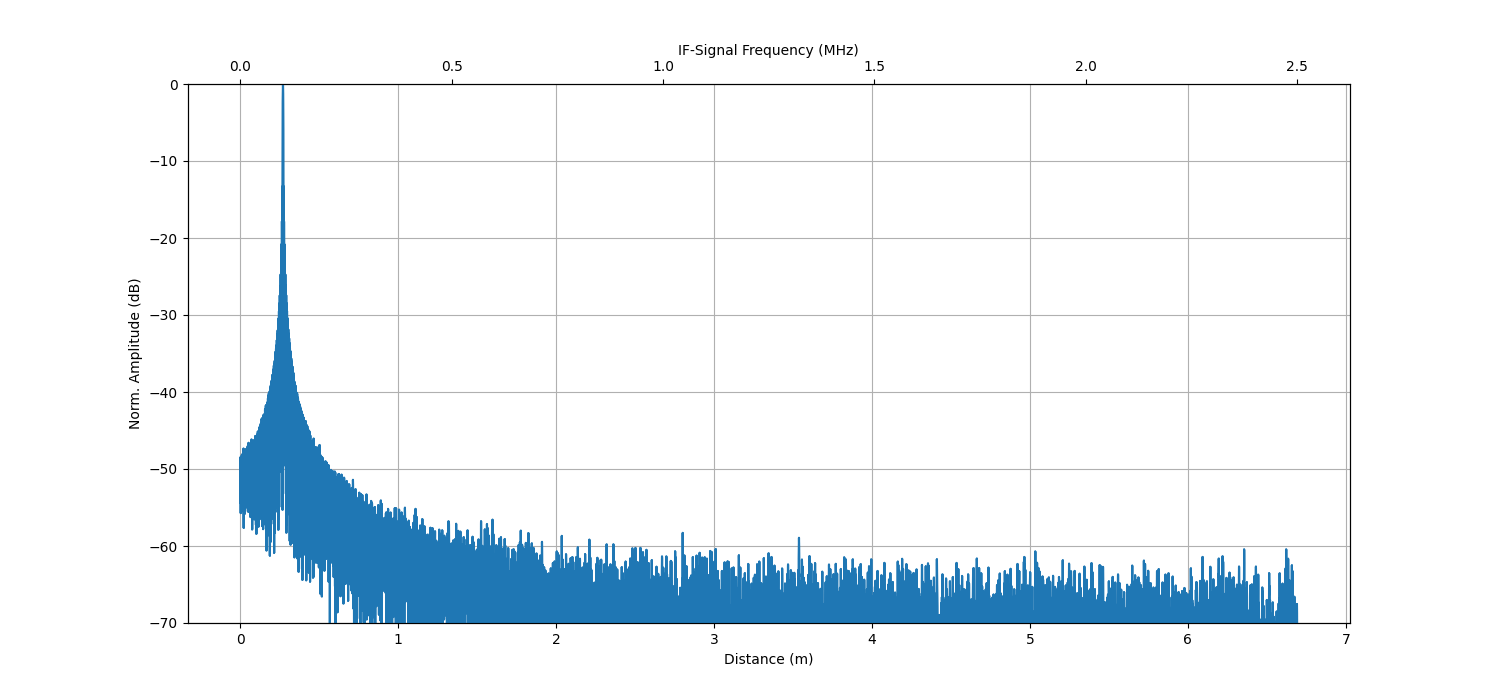

In [9]:
%matplotlib widget
import ipywidgets as interactive
import matplotlib.pyplot as plt

# Create and setup plot
fig = plt.figure(figsize=(15,7))
ax_range_profile = fig.add_subplot(111)
ax_range_profile.set_xlabel('Distance (m)') 
ax_range_profile.set_ylabel('Norm. Amplitude (dB)')
ax_range_profile.set_ylim([-70, 0])
ax_range_profile.grid()
ax_range_profile_top = ax_range_profile.twiny()
ax_range_profile_top.set_xlabel('IF-Signal Frequency (MHz)')

@interactive.interact(WindowFunc=DataProcessor.window_list(), Target0Dist=(0.001, 1.5, 0.001), Target0Ampl=(0.001, 1, 0.01))
def update(WindowFunc='boxcar', Target0Dist = Targets[0].distance, Target0Ampl = Targets[0].amplitude):
    # Update values
    Targets[0].distance = Target0Dist;
    Targets[0].amplitude = Target0Ampl;
    Processor.window = WindowFunc
    
    # Run simulation
    if_signal = Radar.simulate([Targets[0]])
    range_profile = Processor.process(if_signal)

    # Clear previous plots and re-plot new data
    ax_range_profile.lines.clear()
    ax_range_profile_top.lines.clear()

    ax_range_profile.plot(Processor.ft_range_dist_axis, 20*np.log10(np.abs(2*range_profile[:len(range_profile)//2])), color='C0')
    ax_range_profile_top.plot(Processor.ft_range_freq_axis/1e6, 20*np.log10(np.abs(2*range_profile[:len(range_profile)//2])), color='C0')

## Multiple Target Environments
Finally we simulate two separate targets with our FMCW radar simulator. Note how the two targets interact with each other, when they come close. You can also try to change the covered bandwidth to see the pulse shape changing.

interactive(children=(FloatSlider(value=126.0, description='f_Start', max=190.0, min=116.0), FloatSlider(value…

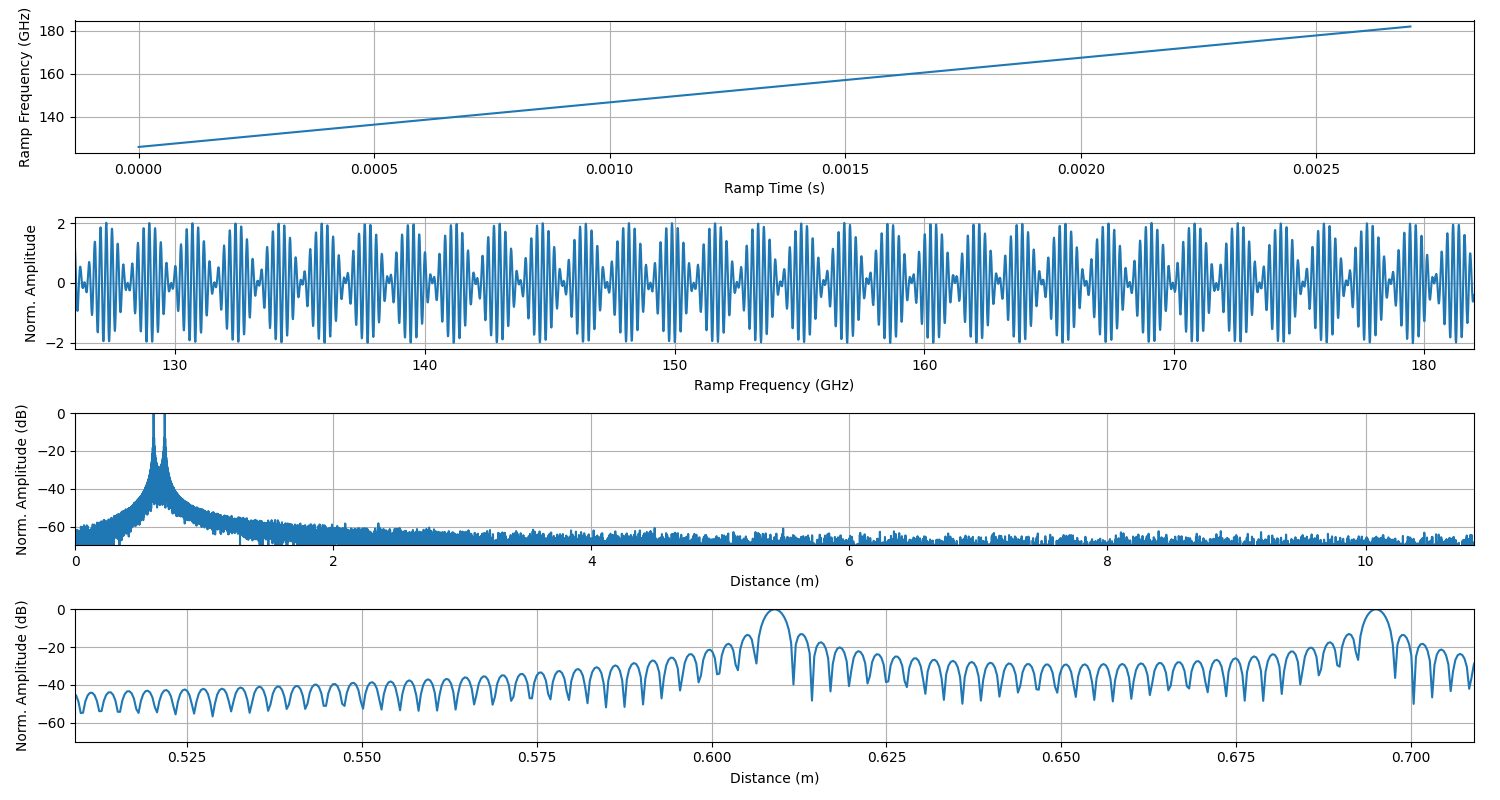

In [18]:
%matplotlib widget
import ipywidgets as interactive
import matplotlib.pyplot as plt

# Create plot
fig = plt.figure(figsize=(15,8))
ax_sweep_frequency = fig.add_subplot(411)
ax_if_signal = fig.add_subplot(412)
ax_range_profile = fig.add_subplot(413)
ax_range_profile_zoom = fig.add_subplot(414)

# Setup plot
ax_sweep_frequency.set_xlabel('Ramp Time (s)') 
ax_sweep_frequency.set_ylabel('Ramp Frequency (GHz)')
ax_sweep_frequency.grid()
ax_if_signal.set_xlabel('Ramp Frequency (GHz)') 
ax_if_signal.set_ylabel('Norm. Amplitude')
ax_if_signal.grid()
ax_range_profile.set_xlabel('Distance (m)') 
ax_range_profile.set_ylabel('Norm. Amplitude (dB)')
ax_range_profile.set_ylim([-70, 0])
ax_range_profile.grid()
ax_range_profile_zoom.set_xlabel('Distance (m)') 
ax_range_profile_zoom.set_ylabel('Norm. Amplitude (dB)')
ax_range_profile_zoom.set_ylim([-70, 0])
ax_range_profile_zoom.grid()

fig.tight_layout()

# Create controls
@interactive.interact(f_Start=(116, 190, 0.1), f_Stop=(116, 190, 0.1),
                      f_IF=(0.5, 20, 0.1), t_Ramp=(0.1, 20, 0.1), WindowFunc=DataProcessor.window_list(), 
                      Target0Dist=(0.001, 1.5, 0.001), Target0Ampl=(0.001, 1, 0.01), 
                      Target1Dist=(0.001, 1.5, 0.001), Target1Ampl=(0.001, 1, 0.01))
def update(f_Start = Radar.f_start/1e9, f_Stop = Radar.f_stop/1e9,
           f_IF=Radar.f_if/1e6, t_Ramp=Radar.t_ramp*1e3, WindowFunc='boxcar',
           Target0Dist = Targets[0].distance, Target0Ampl = Targets[0].amplitude, 
           Target1Dist = Targets[1].distance, Target1Ampl = Targets[1].amplitude):
    
    # Update global model variables
    Targets[0].distance = Target0Dist;
    Targets[1].distance = Target1Dist;
    Targets[0].amplitude = Target0Ampl;
    Targets[1].amplitude = Target1Ampl;
    Radar.f_start = f_Start*1e9;
    Radar.f_stop = f_Stop*1e9;
    Radar.f_if = f_IF*1e6;
    Radar.t_ramp = t_Ramp / 1e3
    Processor.window = WindowFunc
    
    # Run simulation
    if_signal = Radar.simulate(Targets)
    range_profile = Processor.process(if_signal)

    # Clear previous plots, plot new data and set new axis limits
    ax_sweep_frequency.lines.clear()
    ax_if_signal.lines.clear()
    ax_range_profile.lines.clear()
    ax_range_profile_zoom.lines.clear()
    
    ax_sweep_frequency.plot(Processor.ft_sweep_time_axis, Processor.ft_sweep_freq_axis/1e9, color='C0')
    ax_if_signal.plot(Processor.ft_sweep_freq_axis/1e9, if_signal, color='C0')
    ax_range_profile.plot(Processor.ft_range_dist_axis, 20*np.log10(2 * np.abs(range_profile[:len(range_profile)//2])), color='C0')
    ax_range_profile_zoom.plot(Processor.ft_range_dist_axis, 20*np.log10(2 * np.abs(range_profile[:len(range_profile)//2])), color='C0')
    
    ax_if_signal.set_xlim([Radar.f_start/1e9, Radar.f_stop/1e9])
    ax_range_profile.set_xlim([0, max(Processor.ft_range_dist_axis)])
    ax_range_profile_zoom.set_xlim([Target0Dist-0.1, Target0Dist+0.1])
    